# Colormap Normalization
[Colormap Normalizations — Matplotlib 3.4.2 documentation](https://matplotlib.org/stable/gallery/userdemo/colormap_normalizations.html#sphx-glr-gallery-userdemo-colormap-normalizations-py)

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation

In [2]:
# Collect .athdf outputs
athinput = athena_read.athinput('../nonlinear/BA/athinput.si')
outputs = sorted(list(Path('../nonlinear/BA/athdf').glob(athinput["job"]["problem_id"]+'.out2.*.athdf')))

In [3]:
# Init sim constants and grid
nx1 = athinput['mesh']['nx1']                # num. radial zones
nx2 = athinput['mesh']['nx2']                # num. vertical zones
nx3 = athinput['mesh']['nx3']                # num. azimuthal zones
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
epsilon = athinput['problem']['epsilon']   # avg. dust/gas ρ-ratio in BG state
Np_tot = athinput['problem']['npx1']\
    *athinput['problem']['npx2']\
    *athinput['problem']['npx3']           # total number of particles
Np = Np_tot/nx1/nx2/nx3                    # theo avg num particles per cell
H = c_s / Omega                            # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf(outputs[0])
xf, zf = data['x1f'] / H, data['x2f'] / H

In [4]:
# Load data into memory
times, rhops, rhopmaxs = [], [], []

for output in outputs:
    data = athena_read.athdf(output)
    times.append(data['Time'] / T)
    rhops.append(data['rhop'][0])          # [0]  flattens 3D array
    rhopmaxs.append(np.amax(data['rhop']))

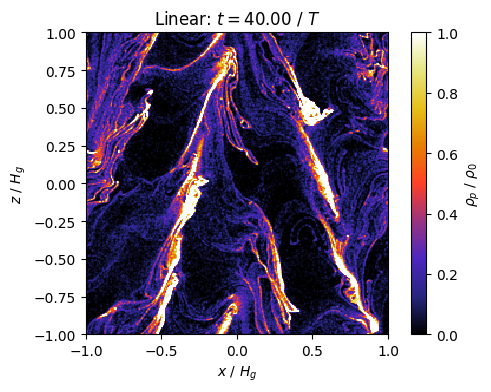

In [5]:
# Linear
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.set_title('Linear: $t={:.2f}$ / $T$'.format(times[0]))
ax.set_xlabel('$x$ / $H_g$')
ax.set_ylabel('$z$ / $H_g$')
img = ax.pcolormesh(xf, zf, rhops[0], vmax=1, cmap='CMRmap')
cb = plt.colorbar(img)
cb.set_label(r'$\rho_p$ / $\rho_0$')

In [6]:
hits = np.count_nonzero(rhops[0]>1)
hits/rhops[0].size

0.0322418212890625

## Minimum dust density
We find the quantized minimum dust particle mass density, $\rho_\textrm{p,min}$, to set as our normalized, logarithmic colormap minimum value, `LogNorm(vmin)`, as follows.
The problem's grid resolution is $128 \times 128$ cells.
With $256 \times 256$ total particles, this gives an initial, quantized dust particle number density of four (4) particles per cell, $n_\textrm{p,0} = 4.0\,\textrm{part./cell}$.
Multiplying this by the initial dust-to-gas mass ratio in the equilibrium state, $\epsilon = 0.2$, gives the dust mass density $\rho_0 = \epsilon n_\textrm{p,0} = 0.8\,\textrm{mass/cell}$.
A non-zero, minimum, quantized particle density corresponds to one (1) particle in a cell, $n_\textrm{p,min} = 1.0\,\textrm{part./cell}$;
This corresponds to a minimum, quantized mass density of $\rho_\textrm{p,min} = \epsilon n_\textrm{p,min} = 0.2\,\textrm{mass/cell}$.

### Correction
CC: mean dust density $\overline{\rho_p} \neq \rho_{p0}$

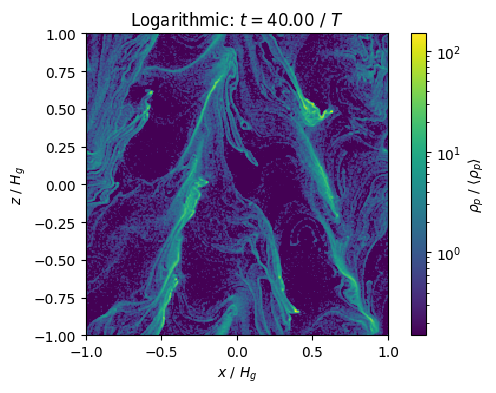

In [7]:
# Pre-clip data w/ NumPy
vmin, vmax = 0.03, 30
clip = np.clip(rhops[0], vmin, vmax)

# Initialize frame
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.set_title('Logarithmic: $t={:.2f}$ / $T$'.format(times[0]))
ax.set_xlabel('$x$ / $H_g$')
ax.set_ylabel('$z$ / $H_g$')
img = ax.pcolormesh(xf, zf, clip/epsilon, norm=colors.LogNorm(vmin/epsilon, vmax/epsilon))
cb = plt.colorbar(img)
cb.set_label(r'$\rho_p$ / $\langle \rho_p \rangle$')

## Tasks
- [x] Use log cmap during saturation phase
- [x] t = ##.## (2 decimal places) in frame titles
- [ ] HOMEWORK: come up w/ min. mass density (quantized) for cmap min
  - [ ] Hint: contain 1 particle in 1 cell
  - [x] Add CC’s notes from Slack
- [x] Fix the range during growth phase
- [x] Use time average or absolute max/min
- [x] Always normalize plots, movies, etc.
- [x] Compute time-averaged $\rho_\textrm{p,max}$ for `vmax` in movie script
- [ ] CC: "**Mean dust density** is _not_ $\rho_0$."
- [ ] Understand $0 \leq \rho_\textrm{p} \leq 0.25$ (or density one particle represents)
  - [ ] Understand the **particle-mesh method**
  - [ ] Re-evaluate `vmin`

